# Speech Emotion Recognition Project

#### Por Liz Marques

## Base de dados: emoUERJ

A base de dados emoUERJ foi desenvolvida na Universidade Estadual do Rio de Janeiro (UERJ) com o principal objetivo de desenvolver modelos de Speech Emotion Recognition (SER; Reconhecimento de emoções na voz) em português, uma vez que existem poucas bases de dados nesse idioma. Na emoUERJ é possível encontrar:

 * 377 arquivos de áudio (tamanho total: 105.1 MB)
 * O banco de dados contém 8 atores, igualmente divididos entre os gêneros
 * Foram disponibilizadas 10 frases e eles tiveram a liberdade de escolher as frases para gravação dos áudios
 * Emoções alvo e total de áudios:
   - Felicidade: 91
   - Raiva: 94
   - Tristeza: 100
   - Neutro: 92

* Abaixo seguem as 10 frases utilizadas neste dataset:
 - Não importa quem está certo.
 - Você perde tempo demais com a Internet.
 - A garrafa está na geladeria.
 - Eu estou me sentindo doente hoje.
 - Eu estou um pouco atrasado.
 - Nos fins de semana, eu sempre ia para a casa dele(a).
 - De quem são essas malas que estão debaixo da mesa?
 - Ele volta na quarta-feira.
 - Já chega! Eu vou tomar um banho e ir para a cama.
 - Você poderia arrumar a mesa, por favor?

 * Cada arquivo de banco de dados corresponde a uma frase gravada por um ator expressando uma das quatro emoções e foi nomeado da seguinte forma:

  - Posição 1: gênero do ator ('m' para homem ou 'w' para mulher)
  - Posições 2 e 3: id do ator (de 01 a 04)
  - Posição 4: emoção (h: felicidade, a: raiva, s: tristeza, n: neutro)
  - Posições 5 e 6: identificação da gravação
  - Por exemplo, o arquivo 'w04a11' foi o décimo primeiro áudio gravado pela atriz 04 interpretando a emoção da raiva.

Fonte: https://zenodo.org/record/5427549#.ZDI6jnbMLrf


# Abordagem: Rede Neural Convolucional criada do zero

---




## Importando as bibliotecas

In [ ]:
import os
import pathlib
from datetime import datetime
import librosa
import librosa.display as ld
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Audio
from tqdm import tqdm
import tensorflow as tf
print(f'[INFO] tensorflow: {tf.__version__}')
from sklearn.preprocessing import LabelEncoder
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import (Activation, Conv1D, Dense, Dropout, Flatten, MaxPooling1D)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set()

[INFO] tensorflow: 2.12.0


#EDA - Exploratory Data Analysis

## Importando o dataset

In [ ]:
# Baixando e carregando a pasta emoUERJ.zip
!wget https://zenodo.org/record/5427549/files/emoUERJ.zip -O emoUERJ.zip

--2023-04-10 21:29:59--  https://zenodo.org/record/5427549/files/emoUERJ.zip
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105084861 (100M) [application/octet-stream]
Saving to: ‘emoUERJ.zip’

emoUERJ.zip         100%[===================>] 100.22M  8.09MB/s    in 90s     

2023-04-10 21:31:31 (1.11 MB/s) - ‘emoUERJ.zip’ saved [105084861/105084861]



In [ ]:
# Descompactando a pasta
!unzip emoUERJ.zip -d "/content/emoUERJ" > /dev/null

In [ ]:
# Removendo o arquivo emoUERJ.zip
!rm emoUERJ.zip

## Criando o dataframe

In [ ]:
# Criando as listas que receberão os dados
gender = []    # Gênero (m = man; w = woman)
actors_id = [] # ID dos atores (de 01 a 04)
emotions = []  # Emoção (h: happiness (felicidade), a: anger(raiva), s: sadness(tristeza), n: neutral(neutro))
rec_id = []    # ID da gravação (recording identification)
full_path = [] # Caminho completo

In [ ]:
# Criando uma função que irá percorrer as pastas e extrair as informações necessárias de cada arquivo
# Informações necessárias: w04a11
def info_extraction(dataset):
  for root, dirs, files in tqdm(os.walk(dataset)):
    for file in files:
      try:
        gen = file[0]
        #print(gen)
        actorsid = file[1:3]
        #print(actorsid)
        label = file[3]
        #print(label)
        recid = file[4:6]
        #print(recid)

        gender.append(gen)
        actors_id.append(actorsid)
        emotions.append(label)
        rec_id.append(recid)

        full_path.append((root, file))
      except ValueError:
        continue

In [ ]:
# Aplicando a função para extrair as informações do dataset emoUERJ
info_extraction("/content/emoUERJ")

2it [00:00, 1186.51it/s]


In [ ]:
# Verificando o total de arquivos
len(full_path)

377

In [ ]:
# Criando o dataframe
emotions_df = pd.DataFrame([gender, actors_id, emotions, rec_id, full_path]).T

In [ ]:
# Criando as colunas do dataframe
emotions_df.columns = ["gender", "actors_id", "emotions", "rec_id", "full_path"]
emotions_df

,gender,actors_id,emotions,rec_id,full_path
0,w,01,h,07,"(/content/emoUERJ/emoUERJ, w01h07.wav)"
1,w,04,n,01,"(/content/emoUERJ/emoUERJ, w04n01.wav)"
2,m,03,a,02,"(/content/emoUERJ/emoUERJ, m03a02.wav)"
3,m,01,n,07,"(/content/emoUERJ/emoUERJ, m01n07.wav)"
4,m,04,s,07,"(/content/emoUERJ/emoUERJ, m04s07.wav)"
...,...,...,...,...,...
372,w,03,n,01,"(/content/emoUERJ/emoUERJ, w03n01.wav)"
373,w,03,h,05,"(/content/emoUERJ/emoUERJ, w03h05.wav)"
374,m,02,s,04,"(/content/emoUERJ/emoUERJ, m02s04.wav)"
375,m,04,h,04,"(/content/emoUERJ/emoUERJ, m04h04.wav)"


In [ ]:
# Fazendo a contagem registros por classe
emotions_df.emotions.value_counts()

s    100
a     94
n     92
h     91
Name: emotions, dtype: int64

In [ ]:
# Criando um dicionário com os gêneros
gender_dict = {"m":"masculino","w":"feminino"}

In [ ]:
# Criando um dicionário com as emoções
emotion_dict = {"h":"felicidade","a":"raiva","s":"tristeza","n":"neutro"}

In [ ]:
# Ajustando os dados das colunas "gender", "emotion" e "full_path"
emotions_df["gender"] = emotions_df["gender"].replace(gender_dict)
emotions_df["emotions"] = emotions_df["emotions"].replace(emotion_dict)
emotions_df["full_path"] = emotions_df["full_path"].apply(lambda x: x[0] + "/" + x[1])

In [ ]:
# Visualizando o dataframe após as alterações
emotions_df

,gender,actors_id,emotions,rec_id,full_path
0,feminino,01,felicidade,07,/content/emoUERJ/emoUERJ/w01h07.wav
1,feminino,04,neutro,01,/content/emoUERJ/emoUERJ/w04n01.wav
2,masculino,03,raiva,02,/content/emoUERJ/emoUERJ/m03a02.wav
3,masculino,01,neutro,07,/content/emoUERJ/emoUERJ/m01n07.wav
4,masculino,04,tristeza,07,/content/emoUERJ/emoUERJ/m04s07.wav
...,...,...,...,...,...
372,feminino,03,neutro,01,/content/emoUERJ/emoUERJ/w03n01.wav
373,feminino,03,felicidade,05,/content/emoUERJ/emoUERJ/w03h05.wav
374,masculino,02,tristeza,04,/content/emoUERJ/emoUERJ/m02s04.wav
375,masculino,04,felicidade,04,/content/emoUERJ/emoUERJ/m04h04.wav


## Visualizando a distribuição

In [ ]:
# Resumo estatístico
# Emoção mais frequente: tristeza
# Total de registros: 100
emotions_df.describe()

,gender,actors_id,emotions,rec_id,full_path
count,377,377,377,377,377
unique,2,4,4,19,377
top,feminino,04,tristeza,07,/content/emoUERJ/emoUERJ/w01h07.wav
freq,197,105,100,32,1


In [ ]:
# Salvando o dataframe no formato .csv
emotions_df.to_csv(os.path.join("/content", "emoUERJ.csv"), index = False)

In [ ]:
# Fazendo a contagem registros por classe
emotions_counts = emotions_df["emotions"].value_counts()
emotions_counts

tristeza      100
raiva          94
neutro         92
felicidade     91
Name: emotions, dtype: int64

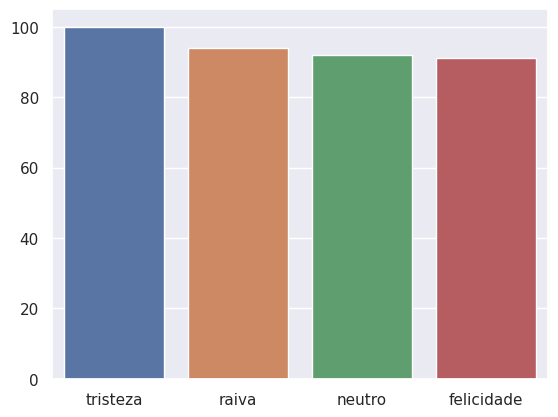

In [ ]:
# Visualizando a contagem registros por classe
# Através deste gráfico, podemos concluir que temos um dataset razoavelmente balanceado
sns.barplot(x=emotions_counts.index, y=emotions_counts.values)
plt.show()

## Visualizando os dados de áudio
### Waveforms

Canais: (192938,)
Número total de amostras: 192938
Arquivo:  /content/emoUERJ/emoUERJ/m01s10.wav
Taxa de amostragem: 44100
Duração:  4.38


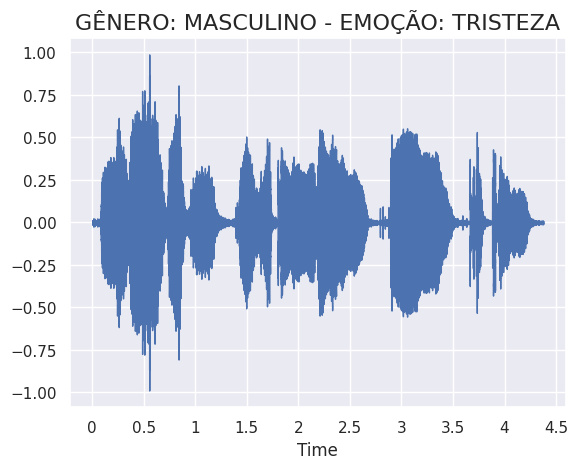

In [ ]:
n_files = emotions_df.shape[0]
rnd = np.random.randint(0, n_files)

fname = emotions_df.full_path[rnd]
data, sample_rate = librosa.load(fname, sr=None)

print("Canais:", data.shape)
print("Número total de amostras:", data.shape[0])
print("Arquivo: ", fname)
print("Taxa de amostragem:", sample_rate)
print("Duração: ", round(len(data) / sample_rate,2))

info = emotions_df.iloc[rnd].values
title_txt = f"gênero: {info[0]} - emoção: {info[2]}"
plt.title(title_txt.upper(), size=16)
ld.waveshow(data, sr=sample_rate)
Audio(data = data, rate = sample_rate)

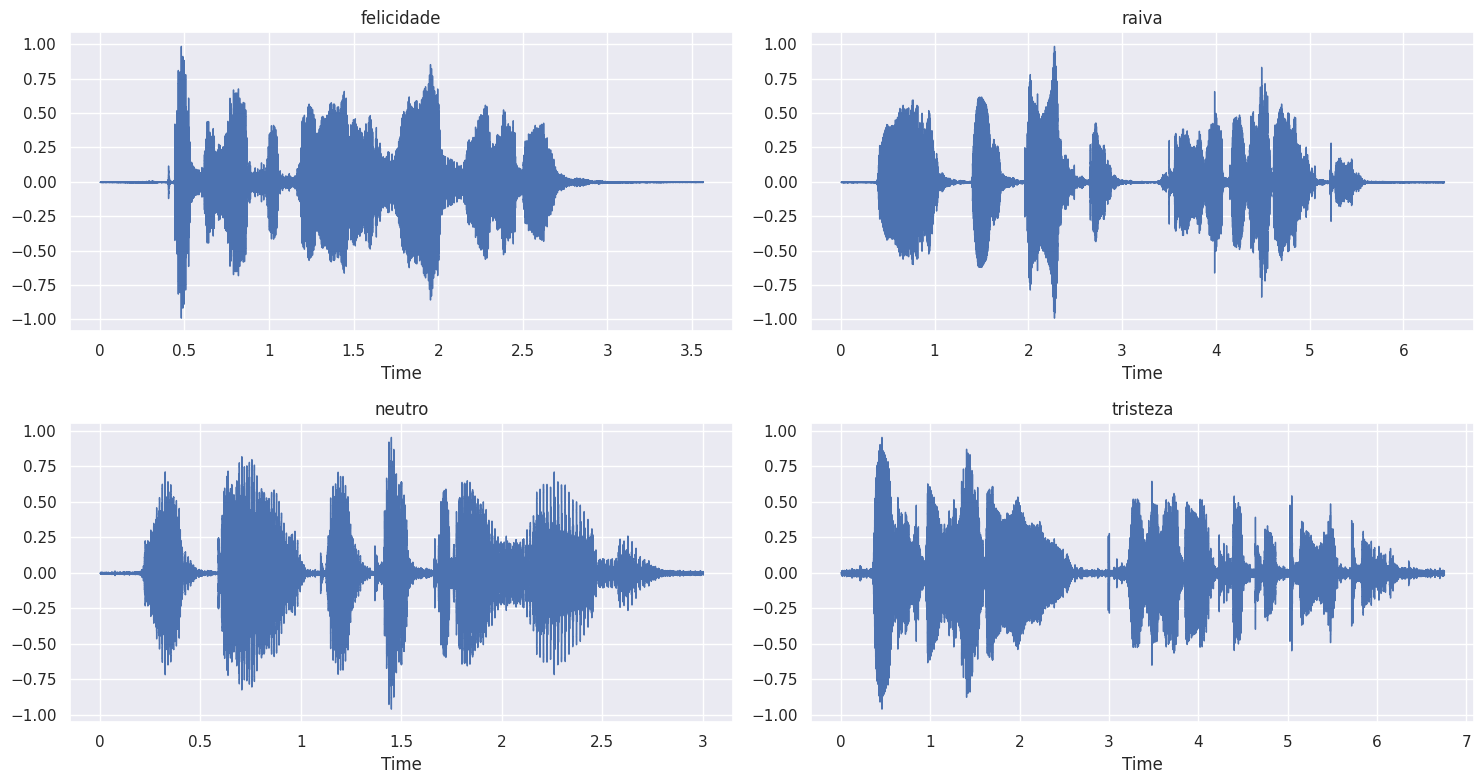

In [ ]:
# Visualizando os waveplots para cada emoção
random_samples = emotions_df.groupby("emotions").sample(1)
audio_samples, labels = random_samples["full_path"].tolist(), random_samples["emotions"].tolist()

rows=2
cols=2
fig, axs = plt.subplots(rows, cols, figsize=(15,8))
index = 0
for col in range(cols):
    for row in range(rows):
        data, sample_rate = librosa.load(audio_samples[index], sr = None)
        librosa.display.waveshow(data, ax=axs[row][col])
        axs[row][col].set_title('{}'.format(labels[index]))
        index += 1
fig.tight_layout()

### Espectrogramas de STFT (Short Time Fourier Transform)

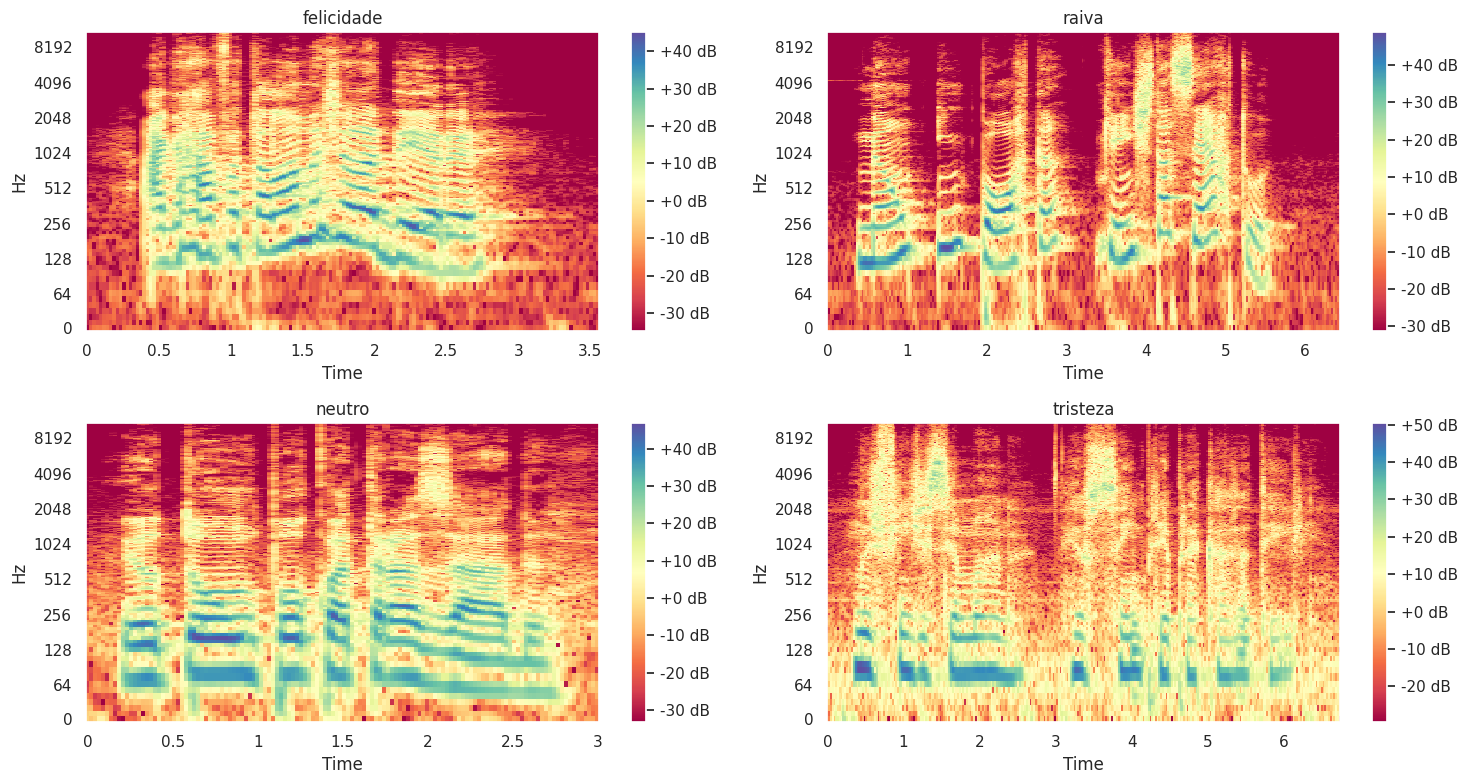

In [ ]:
# Espectrograma que utiliza a Transformada de Fourier de Tempo Curto
fig, axs = plt.subplots(rows, cols, figsize=(15,8))
index = 0
for col in range(cols):
    for row in range(rows):
        data, sample_rate = librosa.load(audio_samples[index], sr = None)
        stft = librosa.stft(y = data)
        stft_db = librosa.amplitude_to_db(np.abs(stft))
        img = librosa.display.specshow(stft_db, x_axis="time", y_axis='log', ax=axs[row][col], cmap = 'Spectral')
        axs[row][col].set_title('{}'.format(labels[index]))
        fig.colorbar(img, ax=axs[row][col], format='%+2.f dB')
        index += 1
fig.tight_layout()

### Espectrogramas de MFCC (Coeficientes Cepstral de Frequência Mel)

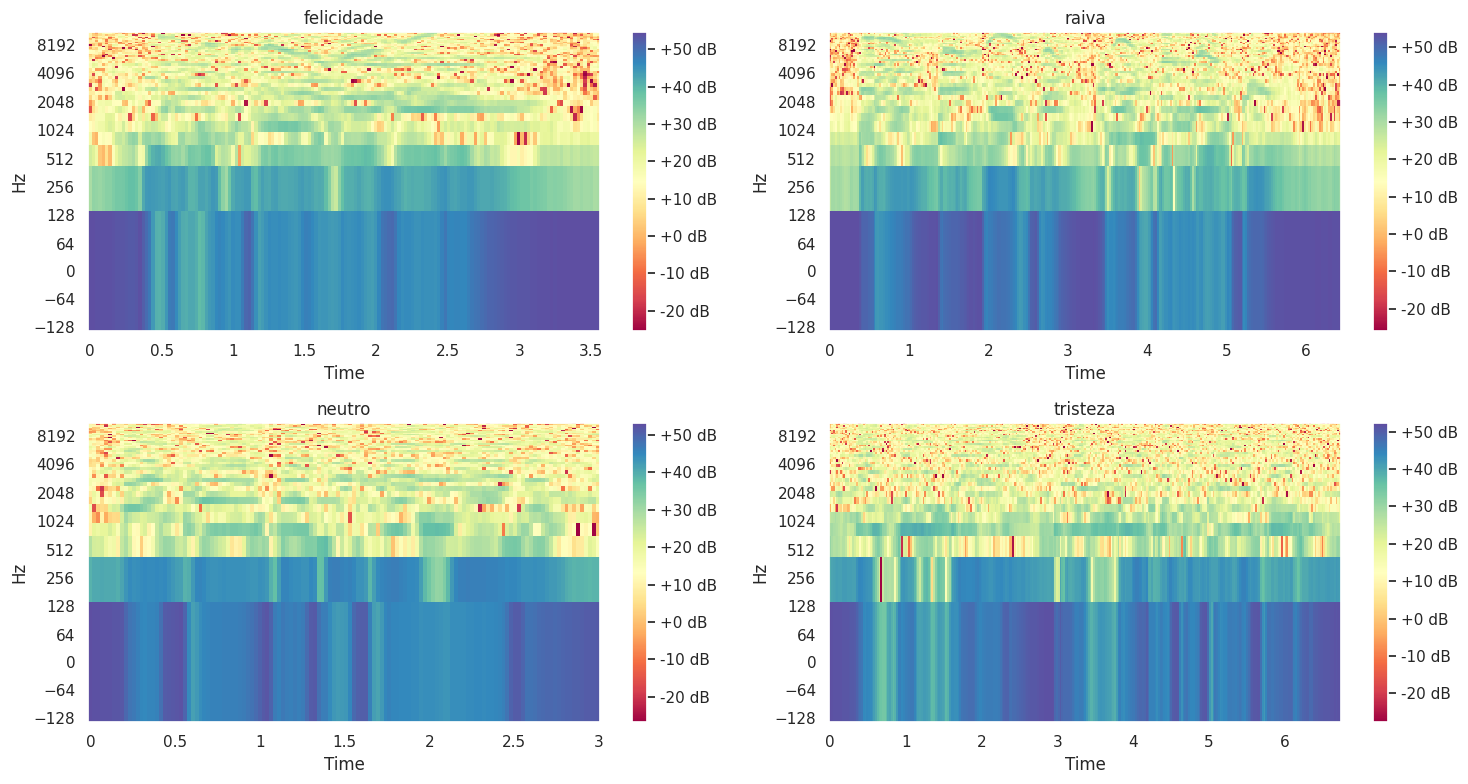

In [ ]:
# Espectrogramas de MFCCs
# Uma vez que os espectrogramas, que nada mais são do que imagens, iremos utilizá-los para treinar uma rede neural convolucional.
# Assim, ela aprenderá a classificar os diferentes tipos de som baseada nas diferenças dos espectrogramas mfcc.
fig, axs = plt.subplots(rows, cols, figsize=(15,8))
index = 0
for col in range(cols):
    for row in range(rows):
        data, sample_rate = librosa.load(audio_samples[index], sr = None)
        mfccs = librosa.feature.mfcc(y = data, sr=sample_rate, n_mfcc=40)
        mfccs_db = librosa.amplitude_to_db(np.abs(mfccs))
        img = librosa.display.specshow(mfccs_db, x_axis="time", y_axis='log', ax=axs[row][col], cmap = 'Spectral')
        axs[row][col].set_title('{}'.format(labels[index]))
        fig.colorbar(img, ax=axs[row][col], format='%+2.f dB')
        index += 1

fig.tight_layout()

# Pré-processamento


### Extraindo as características MFCCs de cada arquivo de áudio do dataset


In [ ]:
# Função que realiza a extração das características
def features_extractor(file_name):
    data, sample_rate = librosa.load(file_name, sr = None, res_type = 'kaiser_fast')
    mfccs_features = librosa.feature.mfcc(y = data, sr = sample_rate, n_mfcc = 40)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis = 0)
    return mfccs_scaled_features

extracted_features=[]
for path in tqdm(emotions_df.full_path.values):
  data = features_extractor(path)
  extracted_features.append([data])

100%|██████████| 377/377 [00:09<00:00, 41.42it/s]


In [ ]:
# Visualizando as características extraídas do 1º registro
extracted_features[0]

[array([-223.48804   ,  146.69518   ,  -23.049818  ,    6.285123  ,
          -1.4755372 ,   14.265263  ,  -10.340043  ,   -8.871662  ,
          -7.761307  ,  -15.40616   ,  -20.892702  ,    9.799486  ,
          -6.965799  ,   -4.0739512 ,    2.714223  ,   -9.093515  ,
          -6.56788   ,    1.7213908 ,   -6.1936593 ,   -6.6705213 ,
          -6.882657  ,   -2.0732799 ,   -2.1224952 ,   -5.1356616 ,
          -7.3747516 ,   -4.720978  ,    0.28504893,   -8.873054  ,
          -6.3878093 ,   -2.0769045 ,   -5.7127967 ,   -4.8913913 ,
          -3.1571617 ,   -6.0563526 ,   -4.1520596 ,   -3.8510668 ,
          -5.4823627 ,   -4.725125  ,   -1.6876041 ,   -0.7492454 ],
       dtype=float32)]

## Convertendo os recursos extraídos para visualização com Pandas

In [ ]:
extracted_features_df = pd.DataFrame(extracted_features, columns = ["features"])
extracted_features_df

,features
0,"[-273.39642, 84.89032, -35.379753, -10.65811, ..."
1,"[-286.74835, 117.156525, 20.127077, 19.153542,..."
2,"[-272.25, 97.078384, -18.904737, 22.751438, 6...."
3,"[-223.48804, 146.69518, -23.049818, 6.285123, ..."
4,"[-302.8874, 109.20672, -0.31706214, 23.506413,..."
...,...
372,"[-279.08786, 99.43578, 6.709421, 25.295828, 5...."
373,"[-297.33044, 102.26005, -31.815605, 4.9453797,..."
374,"[-252.1644, 131.85089, 8.316797, 33.66714, 11...."
375,"[-234.30307, 65.75933, -1.9089304, 36.3767, 10..."


## Dividindo entre atributos classe (class) e atributos previsores (features)

In [ ]:
X = np.array(extracted_features_df["features"].tolist())
y = np.array(emotions_df.emotions.tolist())

In [ ]:
# Visualizando os atributos previsores
X

array([[-2.2348804e+02,  1.4669518e+02, -2.3049818e+01, ...,
        -4.7251248e+00, -1.6876041e+00, -7.4924541e-01],
       [-3.2537286e+02,  9.0143051e+01,  1.6358725e+01, ...,
         7.3287344e-01,  1.4116532e-01,  5.2351725e-01],
       [-3.6387177e+02,  7.2026733e+01, -3.8405945e+01, ...,
        -3.4074979e+00, -2.9798675e+00, -1.4926912e+00],
       ...,
       [-3.1619058e+02,  9.4851204e+01, -8.0367031e+00, ...,
        -1.5747681e+00, -2.5692053e+00, -2.2033756e+00],
       [-3.5101157e+02,  9.5377678e+01, -8.6543970e+00, ...,
        -2.1618973e-01, -1.6337149e+00, -1.0931833e+00],
       [-3.7455078e+02,  1.0538890e+02, -1.3987405e+00, ...,
         3.9213300e+00,  3.2756000e+00,  1.8691326e+00]], dtype=float32)

In [ ]:
# Observando o shape
# 377 linhas -> contendo os áudios
# 40 colunas -> com as características extraídas
X.shape

(377, 40)

In [ ]:
# Visualizando os atributos Classe
y

array(['neutro', 'tristeza', 'felicidade', 'neutro', 'raiva', 'neutro',
       'tristeza', 'tristeza', 'raiva', 'neutro', 'tristeza', 'neutro',
       'felicidade', 'neutro', 'neutro', 'felicidade', 'neutro', 'neutro',
       'felicidade', 'raiva', 'neutro', 'tristeza', 'raiva', 'felicidade',
       'felicidade', 'tristeza', 'tristeza', 'felicidade', 'tristeza',
       'felicidade', 'neutro', 'neutro', 'tristeza', 'neutro',
       'felicidade', 'tristeza', 'tristeza', 'neutro', 'raiva',
       'tristeza', 'felicidade', 'raiva', 'raiva', 'neutro', 'raiva',
       'felicidade', 'felicidade', 'neutro', 'tristeza', 'raiva',
       'neutro', 'tristeza', 'neutro', 'neutro', 'tristeza', 'raiva',
       'raiva', 'tristeza', 'felicidade', 'tristeza', 'neutro',
       'felicidade', 'tristeza', 'tristeza', 'neutro', 'felicidade',
       'tristeza', 'felicidade', 'raiva', 'felicidade', 'neutro', 'raiva',
       'felicidade', 'neutro', 'neutro', 'raiva', 'neutro', 'raiva',
       'neutro', 'raiva',

In [ ]:
# Visualizando a emoção na posição 0
y[0]

'neutro'

In [ ]:
# Visualizando a emoção na posição 1
y[1]

'tristeza'

In [ ]:
# Conversão dos dados categóricos (string) em dados numéricos na variável Y (classe)
labelencoder = LabelEncoder()
y = to_categorical(labelencoder.fit_transform(y))

In [ ]:
# Representação da emoção neutra
# Sequência de um 0, 1 um, e 2 zeros
y[0]

array([0., 1., 0., 0.], dtype=float32)

In [ ]:
# Emoção: tristeza
# Representação: 3 zeros e 1 um
y[1]

array([0., 0., 0., 1.], dtype=float32)

In [ ]:
y

array([[0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [ ]:
# Observando os nomes das classes originais
labelencoder.classes_

array(['felicidade', 'neutro', 'raiva', 'tristeza'], dtype='<U10')

In [ ]:
# Criando as variáveis de treino e de teste
# 20% dos dados para testar
# 80% dos dados para treinar
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
# Para treinar
X_train.shape

(301, 40)

In [ ]:
# Para testar
X_test.shape

(76, 40)

In [ ]:
Y_train.shape

(301, 4)

In [ ]:
Y_test.shape

(76, 4)

In [ ]:
# np.newaxis =  Adicionando a dimensão no final do vetor
# 301 = quantidade de registros p/ treinar, 40 = nº de características, 1 = pode ser utilizar para indicar que temos um arquivo mono
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]
X_train.shape, X_test.shape

((301, 40, 1, 1), (76, 40, 1, 1))

In [ ]:
num_labels = y.shape[1]
num_labels

4

# Criando o modelo

### Criação da estrutura da rede neural

Os espectrogramas extraídos dos arquivos de áudio são como imagens 2D, então podemos usar técnicas de classificação de imagens neles, especificamente Redes Neurais Convolucionais (CNN)!

A arquitetura desta rede neural foi definida com base em alguns testes realizados para obter o resultado esperado. A estrutura pode ser ajustada livremente e comparada aos resultados desta estrutura.

 * Parâmetros:
  * `Sequential`, é a classe para criar a rede neural, pois uma rede neural nada mais é que uma sequência de camadas (camada e entrada, camadas ocultas, camada de saída);  
  * `kernel_size`, o tamanho do kernel (matriz) de convolução;
  * `activation`, função de ativação;
  * `input_shape`, na primeira camada este é o tamanho dos dados de entrada
  * Camada `MaxPooling1D`, que vai fazer a extração das características principais;
  * Camada `Conv1d`, uma rede neural convolucional que realiza a convolução ao longo de apenas uma dimensão;
  * Camada `Flatten`, para transformar de matriz em vetor;
  * Camada `Dense`, quando um neurônio de uma camada está ligado a todas os outros neurônios das outras camadas;
  * `Dropout`, técnica de regularização para diminuir o overfitting;
  * `padding='same'`, indica que adicionamos uma nova coluna composta por somente 0 (zeros) e utilizamos toda a imagem;

In [ ]:
# input_shape = Formato dos dados de entrada
# 40 características
input_shape=(X_train.shape[1],1)
input_shape

(40, 1)

In [ ]:
# Uma rede neural é uma sequência de camadas
# Sequential = classe base para definir uma rede neural no TensorFlow
model=Sequential()

# 1ª Camada de convolução; especificando os dados de entrada = input_shape
# Ou invés de aplicarmos o dropout ou o max pooling, estamos adicionando
# uma nova camada de convolução. Somente depois é que aplicamos o max pooling
model.add(Conv1D(64, kernel_size=(5), activation='relu',input_shape=(X_train.shape[1],1)))

# 2ª Camada de Convolução
model.add(Conv1D(128, kernel_size=(5),activation='relu', padding='same'))

# Aplicamos o Maxpooling para selecionar os maiores valores; utilizando uma matriz 5x5
model.add(MaxPooling1D(pool_size=(5)))

# 3ª Camada Convolucional
model.add(Conv1D(256, kernel_size=(5),activation='relu', padding='same'))

# Aplicamos o MaxPooling
model.add(MaxPooling1D(pool_size=(5)))

# Aplicamos o Dropout = para zeramos 20% dos neurônios, assim, evitamos o overfitting
model.add(Dropout(0.2))

# Aplicamos a camada flaten = para transformar de matriz para o vetor
model.add(Flatten())

#Criação de uma camada densa com 64 neurônios
model.add(Dense(64, activation='relu'))

# Criação de uma camada densa com o número de classes; camada de saída com  8, neste caso
model.add(Dense(num_labels))

# Aplicamos  a função de ativação Softmax = para retornar a probabilidade para cada uma das classes
model.add(Activation('softmax'))

# adam = melhoria na descida do gradiente
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

# Observando os detalhes da estrutura da rede neural
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 36, 64)            384       
                                                                 
 conv1d_4 (Conv1D)           (None, 36, 128)           41088     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 7, 128)           0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 7, 256)            164096    
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 1, 256)           0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 1, 256)           

 # Treinando o modelo
 * `num_epochs`, número de épocas de treinamento
 * `num_batch_size`, isto indica que vamos enviar de 32 em 32 recursos de áudio (32, 64, 96, 128,...8732)

ModelCheckpoint, para salvar o modelo enquanto faz o treinamento
 * `filepath`, caminho onde será salvo o modelo. Para isto temos uma pasta no Drive chamada *saved_models*
 * `verbose`, mostrar mensagens enquanto a rede neural é treinada
 * `save_best_only = True`, para salvar o modelo somente quando houver uma melhora no resultado

Variáveis para efetuar a contagem do tempo de treinamento:
 * `start`, pegando o horário atual de início do treinamento;
 * `duration`, ao final do treinamento, subtrair a hora atual com hora de início do treinamento.

`model_history` para armazenar o histórico de treinamento:
 * `model.fit` para fazer o ajuste do pesos ao longo do treinamento
  * `X_train`, `Y_train`, dados de treinamento
  * `batch_size = num_batch_size` que definimos acima
  * `epochs = num_epochs` que também definimos acima
  * `validation_data=(X_test, Y_test)`, dados de teste para monitorarmos como está o percentual de acerto da rede neural a cada época
  * `callbacks=[checkpointer]`, checkpointer definido anteriormente
  * `verbose = 1`, para mostrar as mensagens

In [ ]:
# Treinamento por nº de épocas
num_epochs = 40

# Enviando de 32 em 32 áudios para o treinamento e ajuste dos pesos
num_batch_size = 32


# Salvando o melhor modelo
checkpointer = ModelCheckpoint(filepath='/content/saved_models/speech_emotion_recognition_model_2.hdf5',
                               verbose=1, save_best_only=True)

# Definindo o earlystopping para evitar o overfitting
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

start = datetime.now()
model_history = model.fit(X_train, Y_train, batch_size=num_batch_size, epochs=num_epochs,
                          validation_data=(X_test, Y_test), callbacks=[checkpointer, callback], verbose=1)
duration = datetime.now() - start
print("[INFO] treinamento concluído em: ", duration)

Epoch 1/40
10/10 [==============================] - ETA: 0s - loss: 0.1211 - accuracy: 0.9601
Epoch 1: val_loss improved from inf to 0.67302, saving model to /content/saved_models/speech_emotion_recognition_model_2.hdf5
10/10 [==============================] - 0s 31ms/step - loss: 0.1211 - accuracy: 0.9601 - val_loss: 0.6730 - val_accuracy: 0.7237
Epoch 2/40
 9/10 [==========================>...] - ETA: 0s - loss: 0.0614 - accuracy: 0.9965
Epoch 2: val_loss improved from 0.67302 to 0.42761, saving model to /content/saved_models/speech_emotion_recognition_model_2.hdf5
10/10 [==============================] - 0s 29ms/step - loss: 0.0674 - accuracy: 0.9934 - val_loss: 0.4276 - val_accuracy: 0.8684
Epoch 3/40
10/10 [==============================] - ETA: 0s - loss: 0.0869 - accuracy: 0.9701
Epoch 3: val_loss improved from 0.42761 to 0.40722, saving model to /content/saved_models/speech_emotion_recognition_model_2.hdf5
10/10 [==============================] - 0s 28ms/step - loss: 0.0869 - a

# Avaliando o modelo

In [ ]:
# Importando o modelo pré treinado
model = tensorflow.keras.models.load_model("/content/saved_models/speech_emotion_recognition_model_2.hdf5")

In [ ]:
model.evaluate(X_test,Y_test, verbose=0)

[0.4072158932685852, 0.8684210777282715]

In [ ]:
print(model_history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


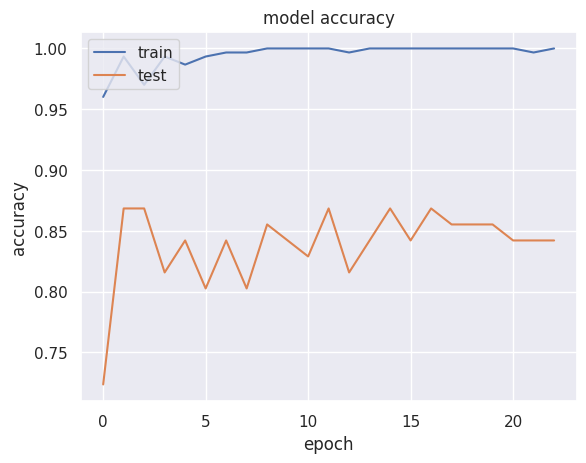

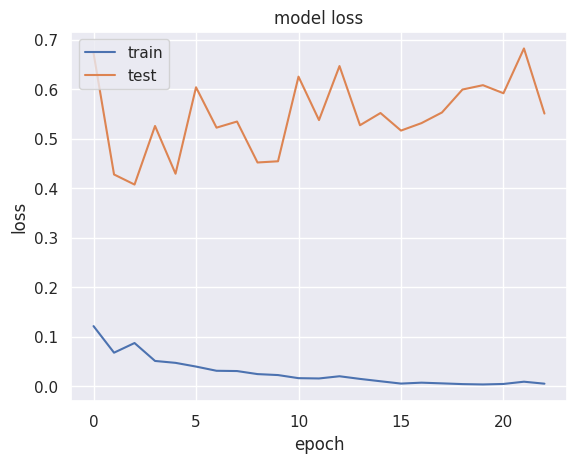

In [ ]:
# Accuracy (do treinamento) = é normal que ele seja maior na base de dados de treinamento
# do que na base de dados de teste, pois indica que a rede neural está sendo avaliada com os mesmos
# dados que ela foi treinada

# loss = temos um loss(erro) maior na base de dados de teste

plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Comparando as classes reais com as classes previstas

In [ ]:
predictions = predictions.astype(int).flatten()
# inverse_transform = para termos os valores relacionados as classes ao invés dos números
predictions = (labelencoder.inverse_transform((predictions)))
predictions = pd.DataFrame({'Classes Previstas': predictions})

In [ ]:
predictions

,Classes Previstas
0,raiva
1,felicidade
2,neutro
3,felicidade
4,raiva
...,...
71,raiva
72,felicidade
73,raiva
74,raiva


In [ ]:
# Buscando os dados atuais
actual = Y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (labelencoder.inverse_transform((actual)))
actual = pd.DataFrame({'Classes Reais': actual})

In [ ]:
actual

,Classes Reais
0,raiva
1,raiva
2,neutro
3,felicidade
4,raiva
...,...
71,raiva
72,felicidade
73,raiva
74,raiva


In [ ]:
# Unindo os dois datasets para fazer uma comparação
finaldf = actual.join(predictions)
finaldf[30:40]

,Classes Reais,Classes Previstas
30,felicidade,felicidade
31,tristeza,tristeza
32,neutro,neutro
33,raiva,raiva
34,felicidade,raiva
35,tristeza,tristeza
36,raiva,felicidade
37,tristeza,tristeza
38,raiva,raiva
39,felicidade,felicidade


### Exibindo a Matriz de confusão

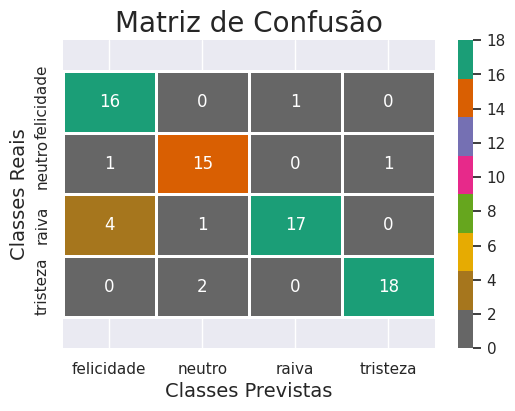

In [ ]:
# Gerando a matriz de confusão para analisar o desempenho em cada uma das classe
cm = confusion_matrix(actual, predictions)
plt.figure(figsize = (6, 4))
cm = pd.DataFrame(cm , index = [i for i in labelencoder.classes_] , columns = [i for i in labelencoder.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Dark2_r', linewidth=1, annot=True, fmt='g')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Matriz de Confusão', size=20)
plt.xlabel('Classes Previstas', size=14)
plt.ylabel('Classes Reais', size=14)
plt.show()

### Visualizando a taxa e acerto para cada uma das classes

In [ ]:
# O melhor resultado é da classe Felicidade
# O algoritmo consegue classificar corretamente 94% dos áudios
# da classe Felicidade e, quando isso ocorre, a precisão é de 76%.

# O pior resultado é da classe Raiva
# O algoritmo consegue identificar corretamente somente 77% dos áudios da classe
# Raiva e, quando isso ocorre, a precisão é de 94%.
print(classification_report(actual, predictions))

              precision    recall  f1-score   support

  felicidade       0.76      0.94      0.84        17
      neutro       0.83      0.88      0.86        17
       raiva       0.94      0.77      0.85        22
    tristeza       0.95      0.90      0.92        20

    accuracy                           0.87        76
   macro avg       0.87      0.87      0.87        76
weighted avg       0.88      0.87      0.87        76



# Testando o modelo em arquivos de áudio

In [ ]:
def getInfo(data, sample_rate):
  print("Canais: ", data.shape)
  print("Número total de amostras: ", data.shape[0])
  print("Taxa de amostragem: ", sample_rate)
  print("Duração: ",  len(data) / sample_rate)

def predictSound(AUDIO, info = False, plot_waveform = False, plot_spectrogram = False):
  # Carregando o áudio
  audio, sample_rate = librosa.load(AUDIO, sr = None, res_type="kaiser_fast")
  # Extraindo as caracteríticas MFCC, pois, para fazer a previsão,
  # os dados precisam estar no mesmo formato de acordo com o treinamento da rede neural
  mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
  # Aplicando a normalização
  mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
  # Convertendo de matriz para vetor
  mfccs_scaled_features = mfccs_scaled_features.reshape(1,-1)
  # Adicionando a dimensão no final do vetor para ficar no formato do TensorFlow
  mfccs_scaled_features = mfccs_scaled_features[:,:,np.newaxis]
  # Chamando o modelo para fazer a previsão
  predictions = model.predict(mfccs_scaled_features)
  # Retornando a acurácia da previsão
  prediction_percentage = predictions * 100
  prediction_percentage_rounded = np.round(prediction_percentage, 2)
  # Estamos gerando um gráfico de barra, onde cada barra será um categoria/emoção(classes_) diferente
  # Assim, conseguimos observar a probabilidade de ser medo, alegria...
  plt.barh(labelencoder.classes_, predictions[0], color=list("rgbkymc"))
  # Criamos a variável prediction e extraindo índice onde temos  a maior probabilidade
  predictions = predictions.argmax(axis=1)
  # flatten = para converter para vetor
  predictions = predictions.astype(int).flatten()
  # inverse_transform = para converter de número para categoria
  predictions = (labelencoder.inverse_transform((predictions)))
  print("Resultado:", predictions[0])
  print("Acurácia: ",   prediction_percentage_rounded.max())

  if info:
    # Mostrar informações do áudio
    getInfo(audio, sample_rate)


  if plot_waveform:
    plt.figure(figsize=(8,5))
    plt.title("Emoção: " + str(predictions[0]).upper(), size=16)
    plt.xlabel("Tempo (segundos):")
    plt.ylabel("Amplitude")
    ld.waveshow(audio, sr=sample_rate)


  if plot_spectrogram:
    plt.figure(figsize=(8,5))
    mfccs_db = librosa.amplitude_to_db(np.abs(mfccs))
    plt.title("Emoção: " + str(predictions[0]).upper(), size=16)
    ld.specshow(mfccs_db, x_axis="time", y_axis="log", cmap = "Spectral")
    plt.colorbar(format="%+2.f dB")

In [ ]:
# /content/emoUERJ/emoUERJ/w03s09.wav
# "/content/emoUERJ/emoUERJ/m04a05.wav"
AUDIO = "/content/Raiva-2.wav"
audio, sample_rate = librosa.load(AUDIO, sr = None, res_type='kaiser_fast')
Audio(data = audio, rate = sample_rate)

1/1 [==============================] - 0s 27ms/step
Resultado: raiva
Acurácia:  86.72
Canais:  (152576,)
Número total de amostras:  152576
Taxa de amostragem:  48000
Duração:  3.1786666666666665


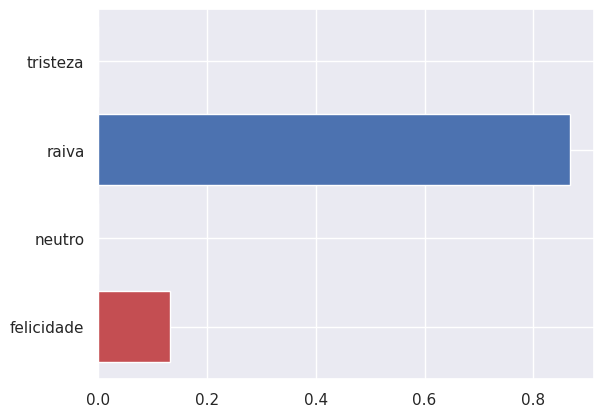

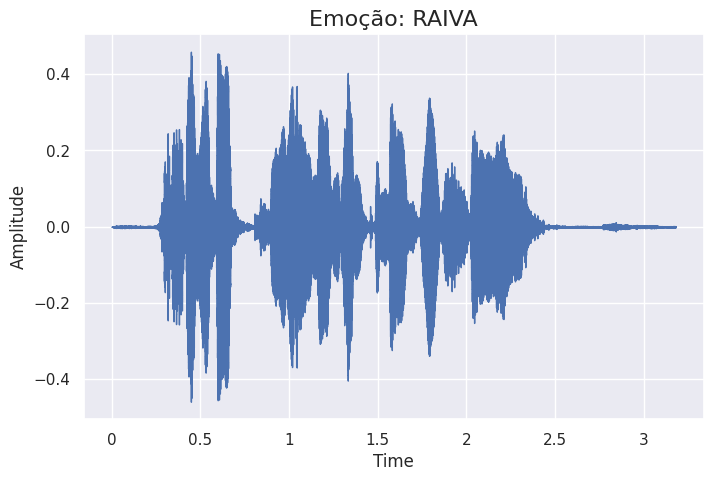

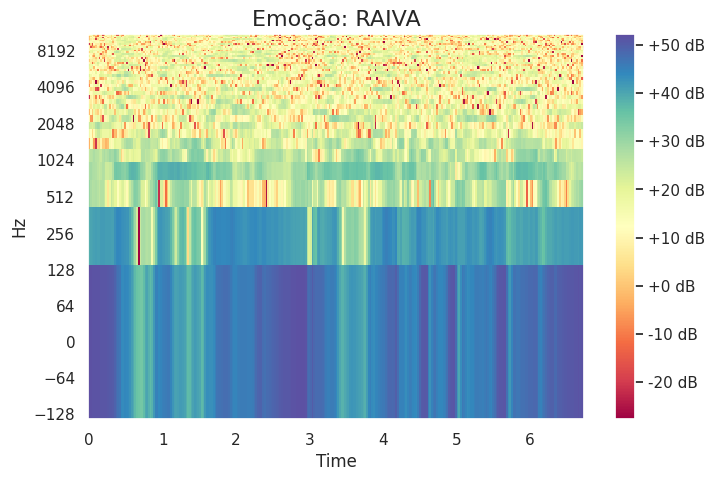

In [ ]:
predictSound(AUDIO, info = True, plot_waveform = True, plot_spectrogram = True)